# Fitting images - patterned stimuli

Here we will introduce how to fit images or patterned stimuli, when the number of independent channels available is smaller than the number of stimulation sources (e.g. for a custom projector system with more LEDs than subframes).

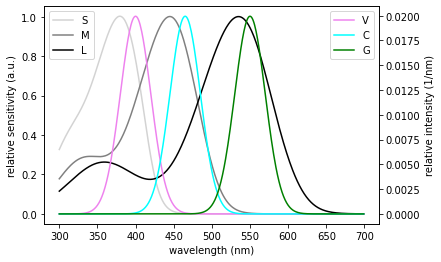

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

import dreye


# load previous model
filters_colors = ['lightgray', 'gray', 'black']
sources_colors = ['violet', 'cyan', 'green']

# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([380, 445, 535])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None])

led_peaks = np.array([400, 465, 550])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters, 
    ### ADDING FILTER UNCERTAINTY
    ### In this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls, 
    # labels for each photoreceptor type (optional)
    labels=['S', 'M', 'L'], 
    # LED array, optional
    sources=sources, 
    # lower bound of each LED, optional
    lb=np.zeros(3), 
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.ones(3) * 0.1, 
    # labels for sources, optional
    sources_labels=['V', 'C', 'G'], 
    baseline=1e-3
)

ax1 = est.filter_plot(colors=filters_colors)
ax2 = plt.twinx(ax1)
est.sources_plot(colors=sources_colors, ax=ax2)

ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('relative sensitivity (a.u.)')
ax2.set_ylabel('relative intensity (1/nm)')

ax1.legend(loc=2)
ax2.legend(loc=1)

(100, 100, 270) (270,)
(100, 100, 400)
(10000, 400)
[0.13112469 0.10144013 0.03367139]
[0 0 0] [255 255 255]


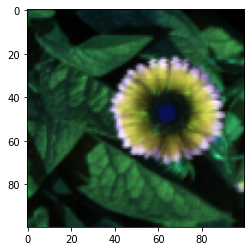

In [2]:
# load previous image
image = np.load(os.path.join('data', 'flower_image.npy'))
image_wls = np.load(os.path.join('data', 'wls_image.npy'))
# convert hyperspectral image in units of W/m2 to photonflux units (uE)
image = dreye.irr2flux(image, image_wls, prefix='micro')
print(image.shape, image_wls.shape)

im = interp1d(image_wls, image, axis=-1, bounds_error=False, fill_value=0)(wls)
print(im.shape)
im_shape = im.shape[:2]
# reshape to 2D
im = im.reshape(-1, wls.size)
print(im.shape)

# register adaptation
est.register_background_adaptation(im.mean(0))
print(est.K)

# target capture
B = est.relative_capture(im)

# rescale value for better contrast, and convert to uint8

def scale_reformat_image(B, im_shape):
    capture_image = (B - np.min(B, 0)) / (np.max(B, 0) - np.min(B, 0))
    capture_image = capture_image.reshape(*im_shape, -1)
    capture_image = (capture_image * 255).astype(np.uint8)
    return capture_image

capture_image = scale_reformat_image(B, im_shape)
print(capture_image.min((0, 1)), capture_image.max((0, 1)))

plt.imshow(capture_image.reshape(*im_shape, -1))

Let's first rescale the capture values accordingly to fit them all within the gamut (see `gamut_corrections.ipynb` tutorial for details). This is a useful preprocessing step for the following fitting procedure especially when the intensity scaling of the system is different from that of the image.

[0.00066015 0.00048893]


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:xlabel='S', ylabel='M'>,
        <AxesSubplot:xlabel='S', ylabel='L'>,
        <AxesSubplot:xlabel='M', ylabel='L'>], dtype=object))

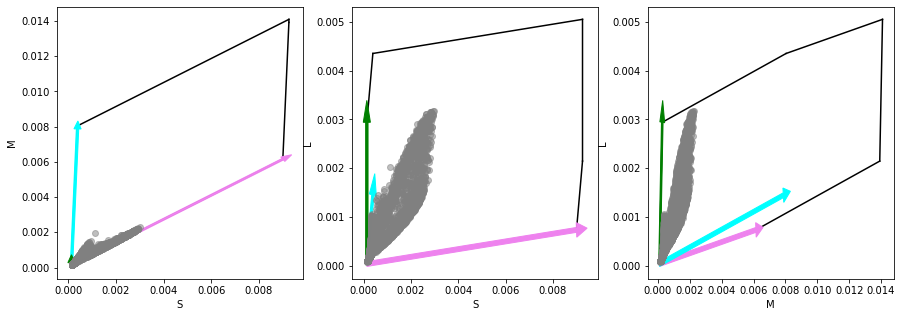

In [3]:
_, scales, Bscaled = est.fit_adaptive(
    B, 
    # maximum difference between scaled intensity and achieved intensity for single sample 
    delta_norm1=1e-5,
    # maximum difference between scaled chromatic value and achieved chromatic value (i.e. l1-normalized sample) for single sample
    delta_radius=1e-4,  # we want to preserve the chromatic values well
    # the two parameters above are highly dependent on the range of values of B
    # here the objectives details are set
    adaptive_objective='max',  # try to obtain the maximum relative intensity and relative chromatic values possible
    scale_w=np.array([0.001, 10]),  # trade-off between intensity and chromatic value for max objective
)

# how intensity and saturation are scaled
print(scales)

est.gamut_plot(Bscaled, colors=sources_colors, ncols=3, fig_kws={'figsize': (15, 5)}, c='gray', alpha=0.5, vectors_kws={'width': 0.0001})

## The problem of fewer subframes than LED sources

Modern custom projector systems allow for the independent control of the subframe number and how each LED is assigned to individual subframe (i.e. they can be combined arbitrarily for each subframe). Here we will go assume that we only have two subframe but that we can arbitrarily combine LEDs in each subframe. To do this we will use the method `fit_decomposition`. See the API reference for more details:

In [4]:
X, P, Bfit = est.fit_decomposition(
    Bscaled, 
    # the number of subframes
    n_layers=2, 
    seed=1,
)
# X are the intensities of each LED for each subframe
# P is the opacity or intensity of each Pixel and subframe
# Thus we get:
# est.K * (P @ X @ est.A.T + baseline) = Bfit
print(X.shape, P.shape, Bfit.shape)

/Users/gucky92/opt/anaconda3/envs/dreye/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(2, 3) (10000, 2) (10000, 3)


Text(0.5, 1.0, 'Intensities of LEDs for subframe 1 and 2 (blue and orange)')

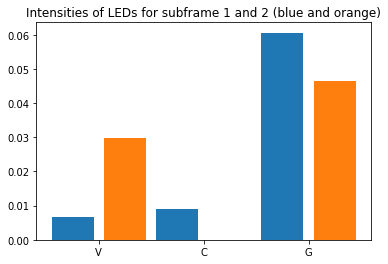

In [5]:
for i in range(2):
    plt.bar(np.arange(0, 6, 2)+i, X[i], width=0.8)
plt.xticks(np.arange(0.5, 6.5, 2), est.sources_labels)
plt.title("Intensities of LEDs for subframe 1 and 2 (blue and orange)")

In [6]:
# goodness-of-fit for the whole image - even with fewer subframes than number of filters
# but with a flexible source assignment for each subframe
from sklearn.metrics import r2_score
r2_score(Bscaled, Bfit)

0.9722969716752816

See the API reference for more detail.